## Importing Libraries

In [1]:
import re
import numpy as np
import string
from typing import List
from typing import Iterable

from unidecode import unidecode

import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

/opt/conda/envs/sentimento/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-22 00:34:28.821023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Data

In [2]:
def load_data_splits():
    raw_train_dataset, test_dataset = load_dataset('maritaca-ai/imdb_pt', split=['train', 'test'])
    raw_train_dataset = raw_train_dataset.train_test_split(0.2)

    return raw_train_dataset['train'], raw_train_dataset['test'], test_dataset

In [3]:
train_dataset, validation_dataset, test_dataset = load_data_splits()

Found cached dataset imdb_pt (/home/codespace/.cache/huggingface/datasets/maritaca-ai___imdb_pt/plain_text/1.0.0/ffeeea85dfdf69a15638f37cdae931de451276b0fbc70c92f7cad159b96abb05)
100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


## Data Processing

In [4]:
VOCAB_SIZE = 10000
MAX_TOKENS = 256
BATCH_SIZE = 32

class DataPipeline:
    def __init__(self) -> None:
        self.vectorizer_layer = layers.TextVectorization(
            max_tokens=VOCAB_SIZE,
            standardize=self.standardize_text,
            split='whitespace',
            ngrams=None,
            output_mode='int',
            output_sequence_length=MAX_TOKENS,
            pad_to_max_tokens=True,
            encoding='utf-16',
        )

    def fit_transform(self, corpus: Iterable[str]):
        corpus_tensor = self.compose_corpus_tensor(corpus)
        self.vectorizer_layer.adapt(corpus_tensor, batch_size=BATCH_SIZE)
        return self.vectorizer_layer(corpus_tensor)

    def transform(self, corpus: Iterable[str]):
        corpus_tensor = self.compose_corpus_tensor(corpus)
        return self.vectorizer_layer(corpus_tensor)

    @staticmethod
    def standardize_text(input_data: Iterable[str]) -> tf.Tensor:
        lowercase = tf.strings.lower(input_data)
        standardized = tf.strings.regex_replace(
            lowercase, 
            '[%s]' % re.escape(string.punctuation),
            ''
        )
        return standardized

    @staticmethod
    def compose_corpus_tensor(corpus: Iterable[str]) -> tf.Tensor:
        corpus_tensor = tf.expand_dims(corpus, -1)
        return corpus_tensor

    @staticmethod
    def split_data_target(dataset: datasets.arrow_dataset.Dataset):
        return np.array(dataset['text']), np.array(dataset['label'])

In [5]:
data_pipeline = DataPipeline()

2023-05-22 00:35:06.909798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 00:35:07.058204: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
train_data, train_labels = data_pipeline.split_data_target(train_dataset)
validation_data, validation_labels = data_pipeline.split_data_target(validation_dataset)
test_data, test_labels = data_pipeline.split_data_target(test_dataset)

: 

: 

In [7]:
X_train = data_pipeline.fit_transform(train_data)

X_val = data_pipeline.transform(validation_data)
X_test = data_pipeline.transform(test_data)

## Model

In [8]:
EMBEDDING_DIM = 2

model = keras.Sequential([
  layers.Embedding(VOCAB_SIZE + 1, EMBEDDING_DIM, input_length=256),
  layers.Flatten(),
  layers.Dropout(rate=0.5),
  layers.Dense(5),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 2)            20002     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 22,573
Trainable params: 22,573
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.metrics.BinaryAccuracy(), tf.metrics.Precision(), tf.metrics.Recall()])

In [12]:
EPOCHS = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=1)

history = model.fit(X_train,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=100,
                    validation_data=(X_val, validation_labels),
                    callbacks=[callback],
                    verbose=1)

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.framework.ops.EagerTensor'>, (<class 'list'> containing values of types {"<class 'int'>"})

In [36]:
history_dict = history.history

def plot_metric(history_dict: dict, metric: str='binary_accuracy', title: str=''):
    ''' Plot the metrics results for Neural Network epochs

    Args:
        history_dict: dictionary with Neural Networks metric results
        metric: name of the metric to be ploted. Default: 'binary_accuracy'
        title: string with plot title
    '''
    train_result = history_dict[metric]
    validation_result = history_dict['val_' + metric]
    epochs = range(1, len(train_result) + 1)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(epochs, train_result, label='train')
    ax.plot(epochs, validation_result, label='validation')
    ax.set_title(title) 
    ax.set_xlabel('epoch')
    ax.set_xticks(epochs)
    plt.legend(loc='best')
    plt.show()

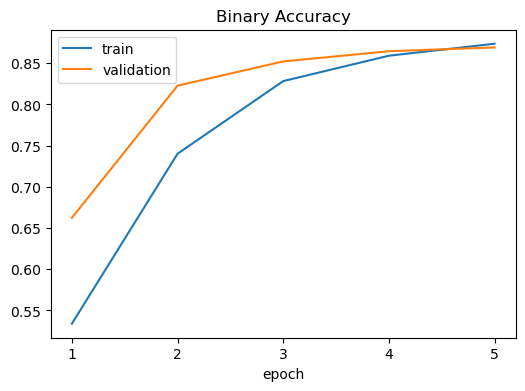

In [37]:
plot_metric(history_dict, metric='binary_accuracy', title='Binary Accuracy')

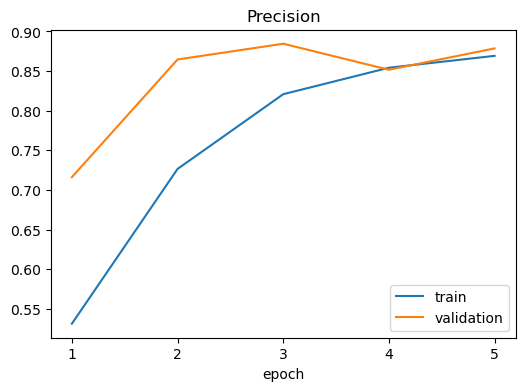

In [39]:
plot_metric(history_dict, metric='precision', title='Precision')

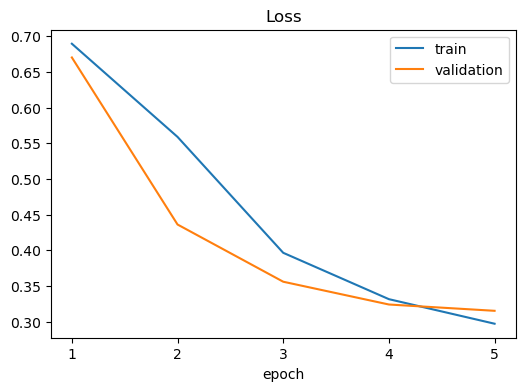

In [33]:
plot_metric(history_dict, metric='loss', title='Loss')

In [44]:
export_model = tf.keras.Sequential([
  data_pipeline.vectorizer_layer,
  model,
])

ValueError: Exception encountered when calling layer "text_vectorization_2" (type TextVectorization).

When using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, None) with rank=2

Call arguments received by layer "text_vectorization_2" (type TextVectorization):
  • inputs=tf.Tensor(shape=(None, None), dtype=string)

In [13]:
model.evaluate(train_data, train_labels)

625/625 [==============================] - 1s 1ms/step - loss: 0.2379 - binary_accuracy: 0.9148 - precision: 0.8780 - recall: 0.9647


[0.2378750443458557, 0.9148499965667725, 0.8780201077461243, 0.964704692363739]

In [14]:
model.evaluate(validation_data, validation_labels)

157/157 [==============================] - 0s 1ms/step - loss: 0.3659 - binary_accuracy: 0.8402 - precision: 0.7916 - recall: 0.9132


[0.3659079670906067,
 0.8402000069618225,
 0.7916222810745239,
 0.9131858944892883]

In [67]:
model.evaluate(test_data, test_labels)

157/157 [==============================] - 0s 2ms/step - loss: 0.3300 - binary_accuracy: 0.8596 - precision_8: 0.8455 - recall_8: 0.8800


[0.3300342261791229,
 0.8596000075340271,
 0.8455034494400024,
 0.8799999952316284]

In [ ]:
import scikitplot as skplt
from sklearn import metrics

In [ ]:
metrics.confusion_matrix(*proba_pred)

In [1]:
import scikitplot as skplt

ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt

#Normalized confusion matrix for the K-NN model

prediction_labels = knn_classifier.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, prediction_labels, normalize=True)
plt.show()

In [ ]:
def cm_plot(cm):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')